<a href="https://colab.research.google.com/github/marc1971/Assignement-Module4-CAS-NLP/blob/main/sumarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Problem and dataset description



According to the order, a pre-trained Tansformer model is fine-tuned with the SAMSum data set. Different settings of some hyperparameters were mused to improove the performance of the model. To messure the quality of the results different ROUGE metrics were used and compared.

The SAMSum dataset contains about 16k messenger-like conversations with summaries. Conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger convesations. The style and register are diversified - conversations could be informal, semi-formal or formal, they may contain slang words, emoticons and typos. Then, the conversations were annotated with summaries. It was assumed that summaries should be a concise brief of what people talked about in the conversation in third person. The SAMSum dataset was prepared by Samsung R&D Institute Poland and is distributed for research purposes. (Source: https://huggingface.co/datasets/samsum)

# B Approaches taken - Contrast transformer based approaches with other NN or traditional approaches


As instructed by the course instructor, I am fine-tuning the T5 model on the SANSum Corpus data set from Hugging Face.
I do various tests by varying the hyperparameters (see below).

The contrastation with a conventional NN or traditional methods are missing here. Instead, some comparisons were made with the results of high-qualilty models (GPT4).

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
pip install transformers datasets evaluate rouge_score

In [ ]:
pip install accelerate -U

In [4]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.26.1')

In [5]:
from datasets import load_dataset

samsum = load_dataset("samsum", split=['train', 'validation', 'test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
samsum[2][0]

{'id': '13862856',
 'dialogue': "Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",
 'summary': "Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."}

In [7]:
from transformers import AutoTokenizer

checkpoint = 't5-small'
#checkpoint2 = "mrm8488/roberta-med-small2roberta-med-small-finetuned-cnn_daily_mail-summarization"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [8]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=124, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [9]:
tokenized_samsum_train = samsum[0].map(preprocess_function, batched=True)
tokenized_samsum_val = samsum[1].map(preprocess_function, batched=True)
tokenized_samsum_test = samsum[2].map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [10]:
# Example of tokanized input data

print('Dialogue:\n',tokenized_samsum_train[34]['dialogue'])
print()
print('Summary:\n',tokenized_samsum_train[34]['summary'])
print()
print('Input-ID:\n',tokenized_samsum_train[34]['input_ids'])
print()
print('Labels:\n',tokenized_samsum_train[34]['labels'])

Dialogue:
 Ted: Any news about weekend?
Jake: About the reunion?
Pia: I am available! Did we talk where?
Jessica: If I move some things around, I can too!
Ted: Great! we should set the place then
Jake: Whoa! I didn't say I could
Ted: Can you?
Jake: Hell yeah man! You know I freelance, worst case scenario I'll work from wherever we are
Ted: Lucky bastard
Jessica: We should meet up where we did last time, it's perfect middle for everyone
Ted: I agree
Pia: Friday night then?
Jess: Sure
Ted: It's a date, I'll book rooms
Jake: See you soon my peeps!

Summary:
 Ted, Jake, Pia, Jessica and Jess are having a reunion this Friday at the same place as the previous one.

Input-ID:
 [21603, 10, 19332, 10, 2372, 1506, 81, 1851, 58, 19806, 10, 4504, 8, 22774, 58, 2745, 9, 10, 27, 183, 347, 55, 3963, 62, 1350, 213, 58, 16908, 10, 156, 27, 888, 128, 378, 300, 6, 27, 54, 396, 55, 19332, 10, 1651, 55, 62, 225, 356, 8, 286, 258, 19806, 10, 2645, 9, 55, 27, 737, 31, 17, 497, 27, 228, 19332, 10, 1072, 25, 5

In [11]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [12]:
import evaluate

rouge = evaluate.load("rouge")

In [13]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Training

In [14]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_samsum_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.05,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_samsum_train,
    eval_dataset=tokenized_samsum_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.261900,1.868962,0.395900,0.162900,0.327000,0.327100,16.761900
2,2.029100,1.823987,0.404100,0.169000,0.333500,0.333600,16.691100
3,1.977200,1.799019,0.407400,0.173500,0.338100,0.338200,16.561700
4,1.940100,1.780620,0.407700,0.174000,0.336300,0.336600,16.820500
5,1.917800,1.770341,0.411600,0.176100,0.340000,0.340200,16.678900
6,1.897300,1.760540,0.415600,0.179000,0.344300,0.344300,16.949900
7,1.879600,1.753825,0.415900,0.181500,0.345300,0.345500,16.678900
8,1.867400,1.752134,0.419500,0.185000,0.348300,0.348500,16.842500
9,1.866000,1.747658,0.419500,0.184200,0.347500,0.347400,16.877900
10,1.860200,1.747685,0.421400,0.186200,0.349700,0.349700,16.854700


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=9210, training_loss=1.9435683193476012, metrics={'train_runtime': 2839.1734, 'train_samples_per_second': 51.888, 'train_steps_per_second': 3.244, 'total_flos': 1.5724596271251456e+16, 'train_loss': 1.9435683193476012, 'epoch': 10.0})

In [16]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1706607907.444be5c735d0.543.0:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Marc71/my_awesome_samsum_model/commit/aa222b95b482d8d937c568135ee7eae8a7a57c29', commit_message='End of training', commit_description='', oid='aa222b95b482d8d937c568135ee7eae8a7a57c29', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

In [ ]:
text2 = "summarize: Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
text3 ="summarize: The evaluation of binary classifiers compares two methods of assigning a binary attribute, one of which is usually a standard method and the other is being investigated. There are many metrics that can be used to measure the performance of a classifier or predictor; different fields have different preferences for specific metrics due to different goals. For example, in medicine sensitivity and specificity are often used, while in computer science precision and recall are preferred. An important distinction is between metrics that are independent on the prevalence (how often each category occurs in the population), and metrics that depend on the prevalence – both types are useful, but they have very different properties."

In [ ]:
len(text3)

740

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="my_awesome_samsum_model")
summarizer(text3)
#[{"summary_text": "The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country."}]

Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


[{'summary_text': 'The evaluation of binary classifiers compares two methods of assigning a binary attribute, one of which is usually a standard method and the other is being investigated.'}]

#C Results and Evaluations


The model was trained using various hyperparameters. It can be seen that the model tends to overfit after more than 3 to 5 training epochs, regardless of the setting of the hyperparameters. The training loss then becomes smaller and smaller, but the validation loss increases sharply, while the rouge1 metric decreases slightly as well.

Test 5 (Hyperparameters: Batchsize: 8, Epochs: 8, Learningrate: 1e-4 and Weight Decay: 0.05) shows the "best" training behaviour but not with the best Rouge1-Score (0.4400). The best Rouge 1-Score was reachd in Test 4 (0.4585)



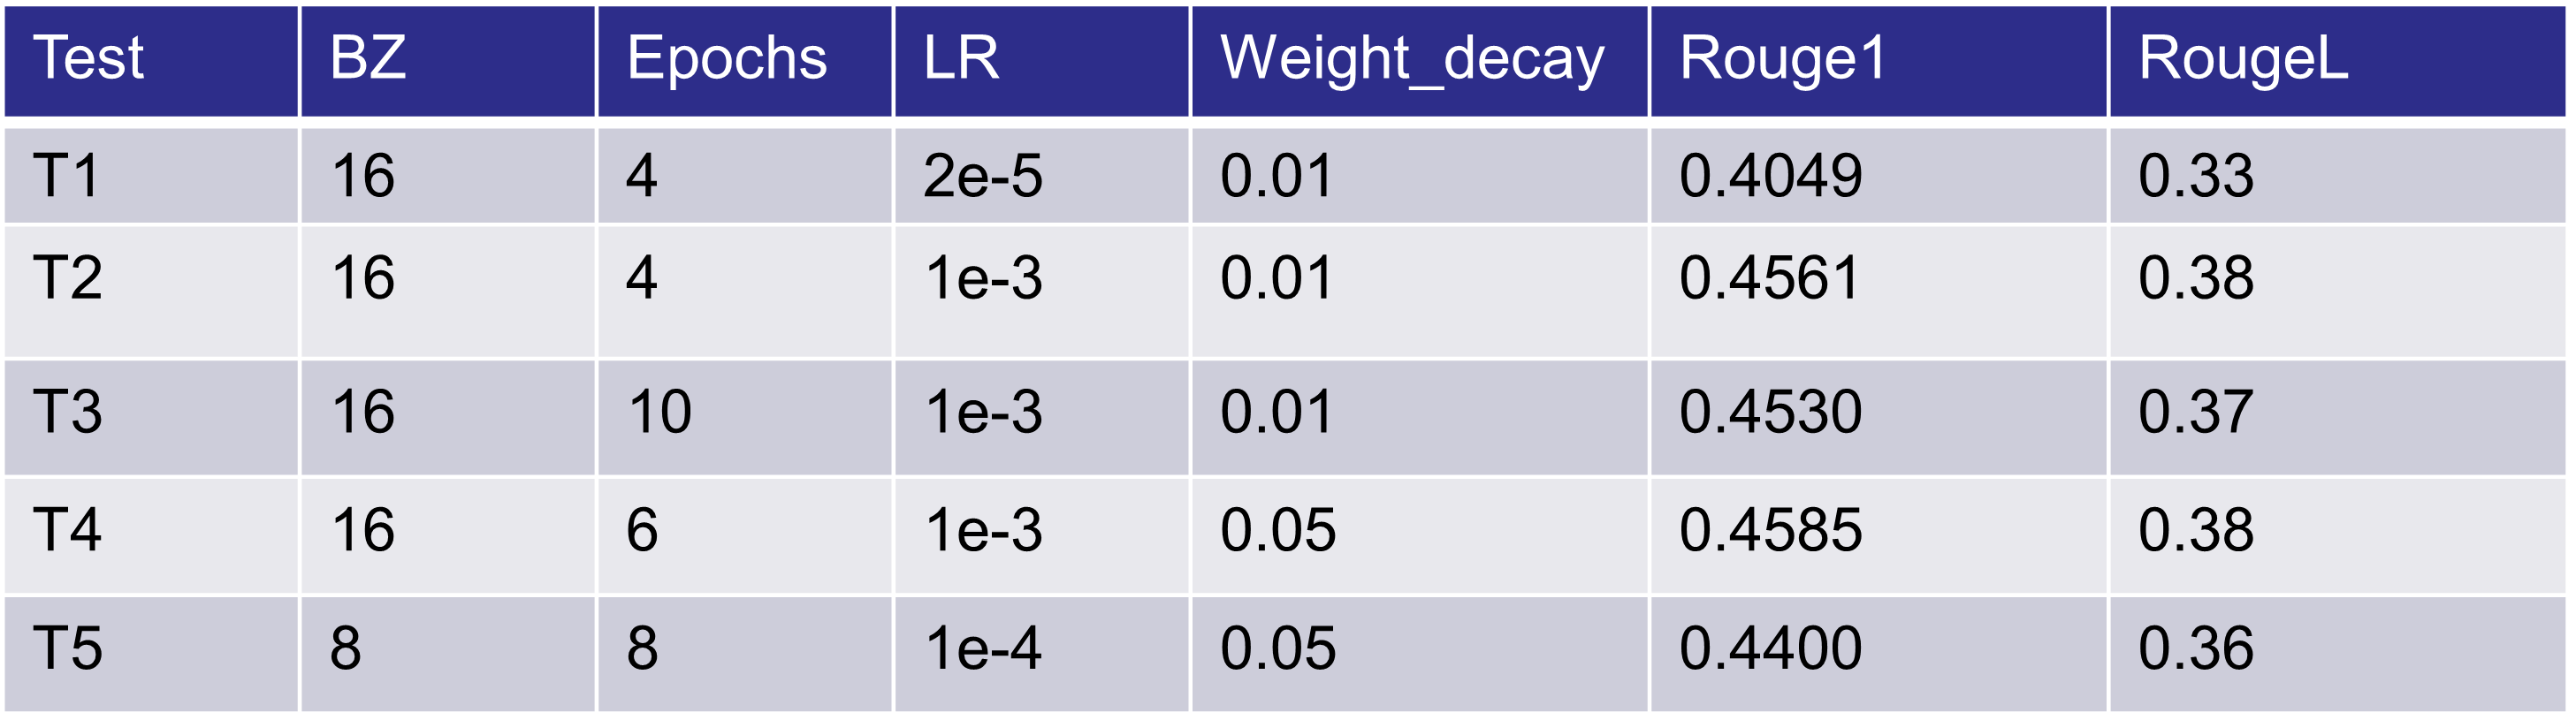

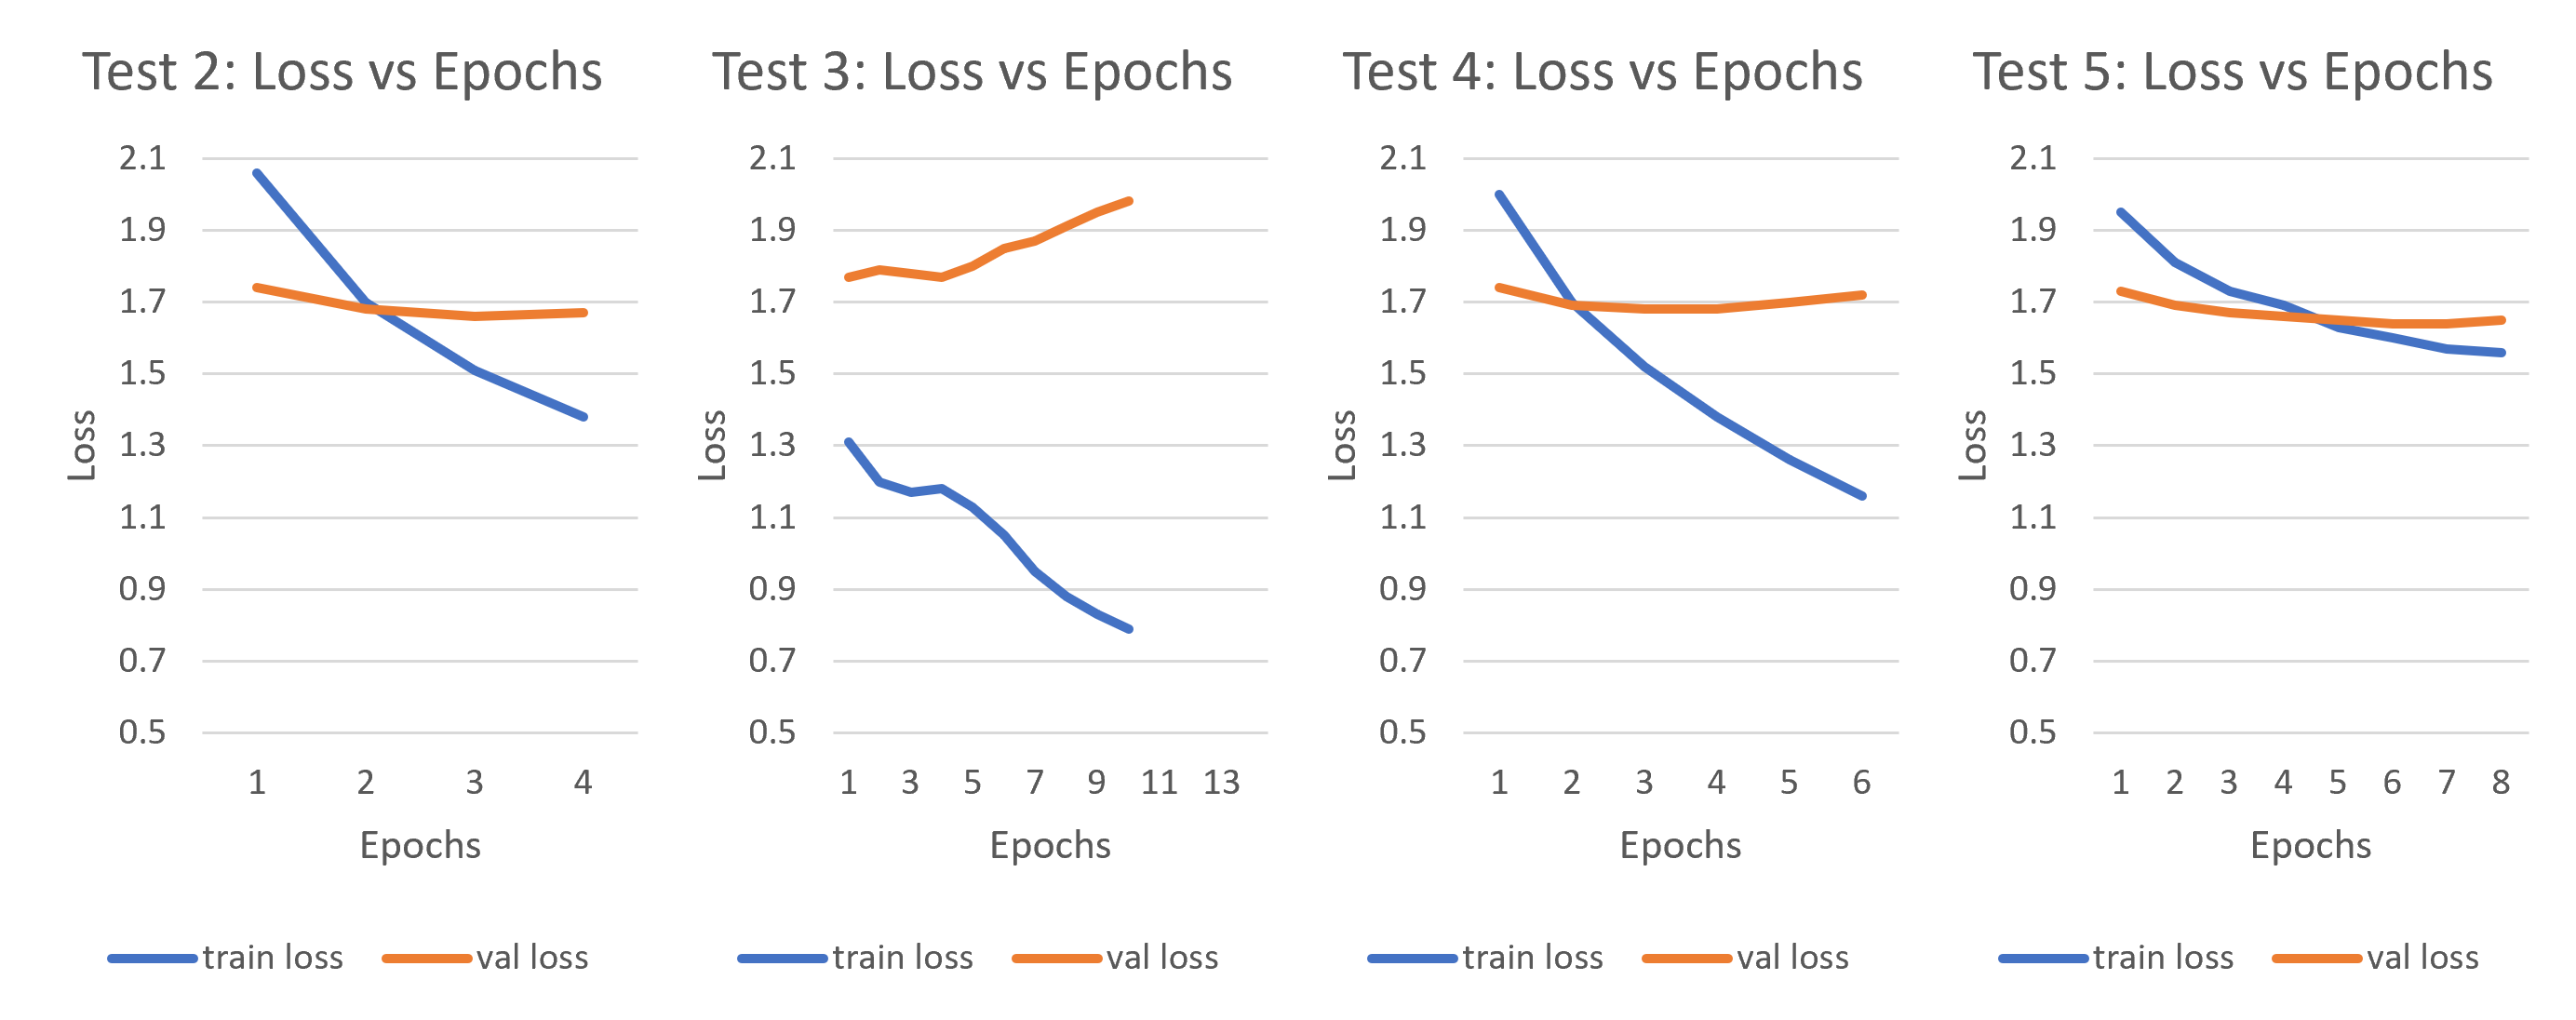

A medium performance can be seen when the model ist applied to summarize chats:

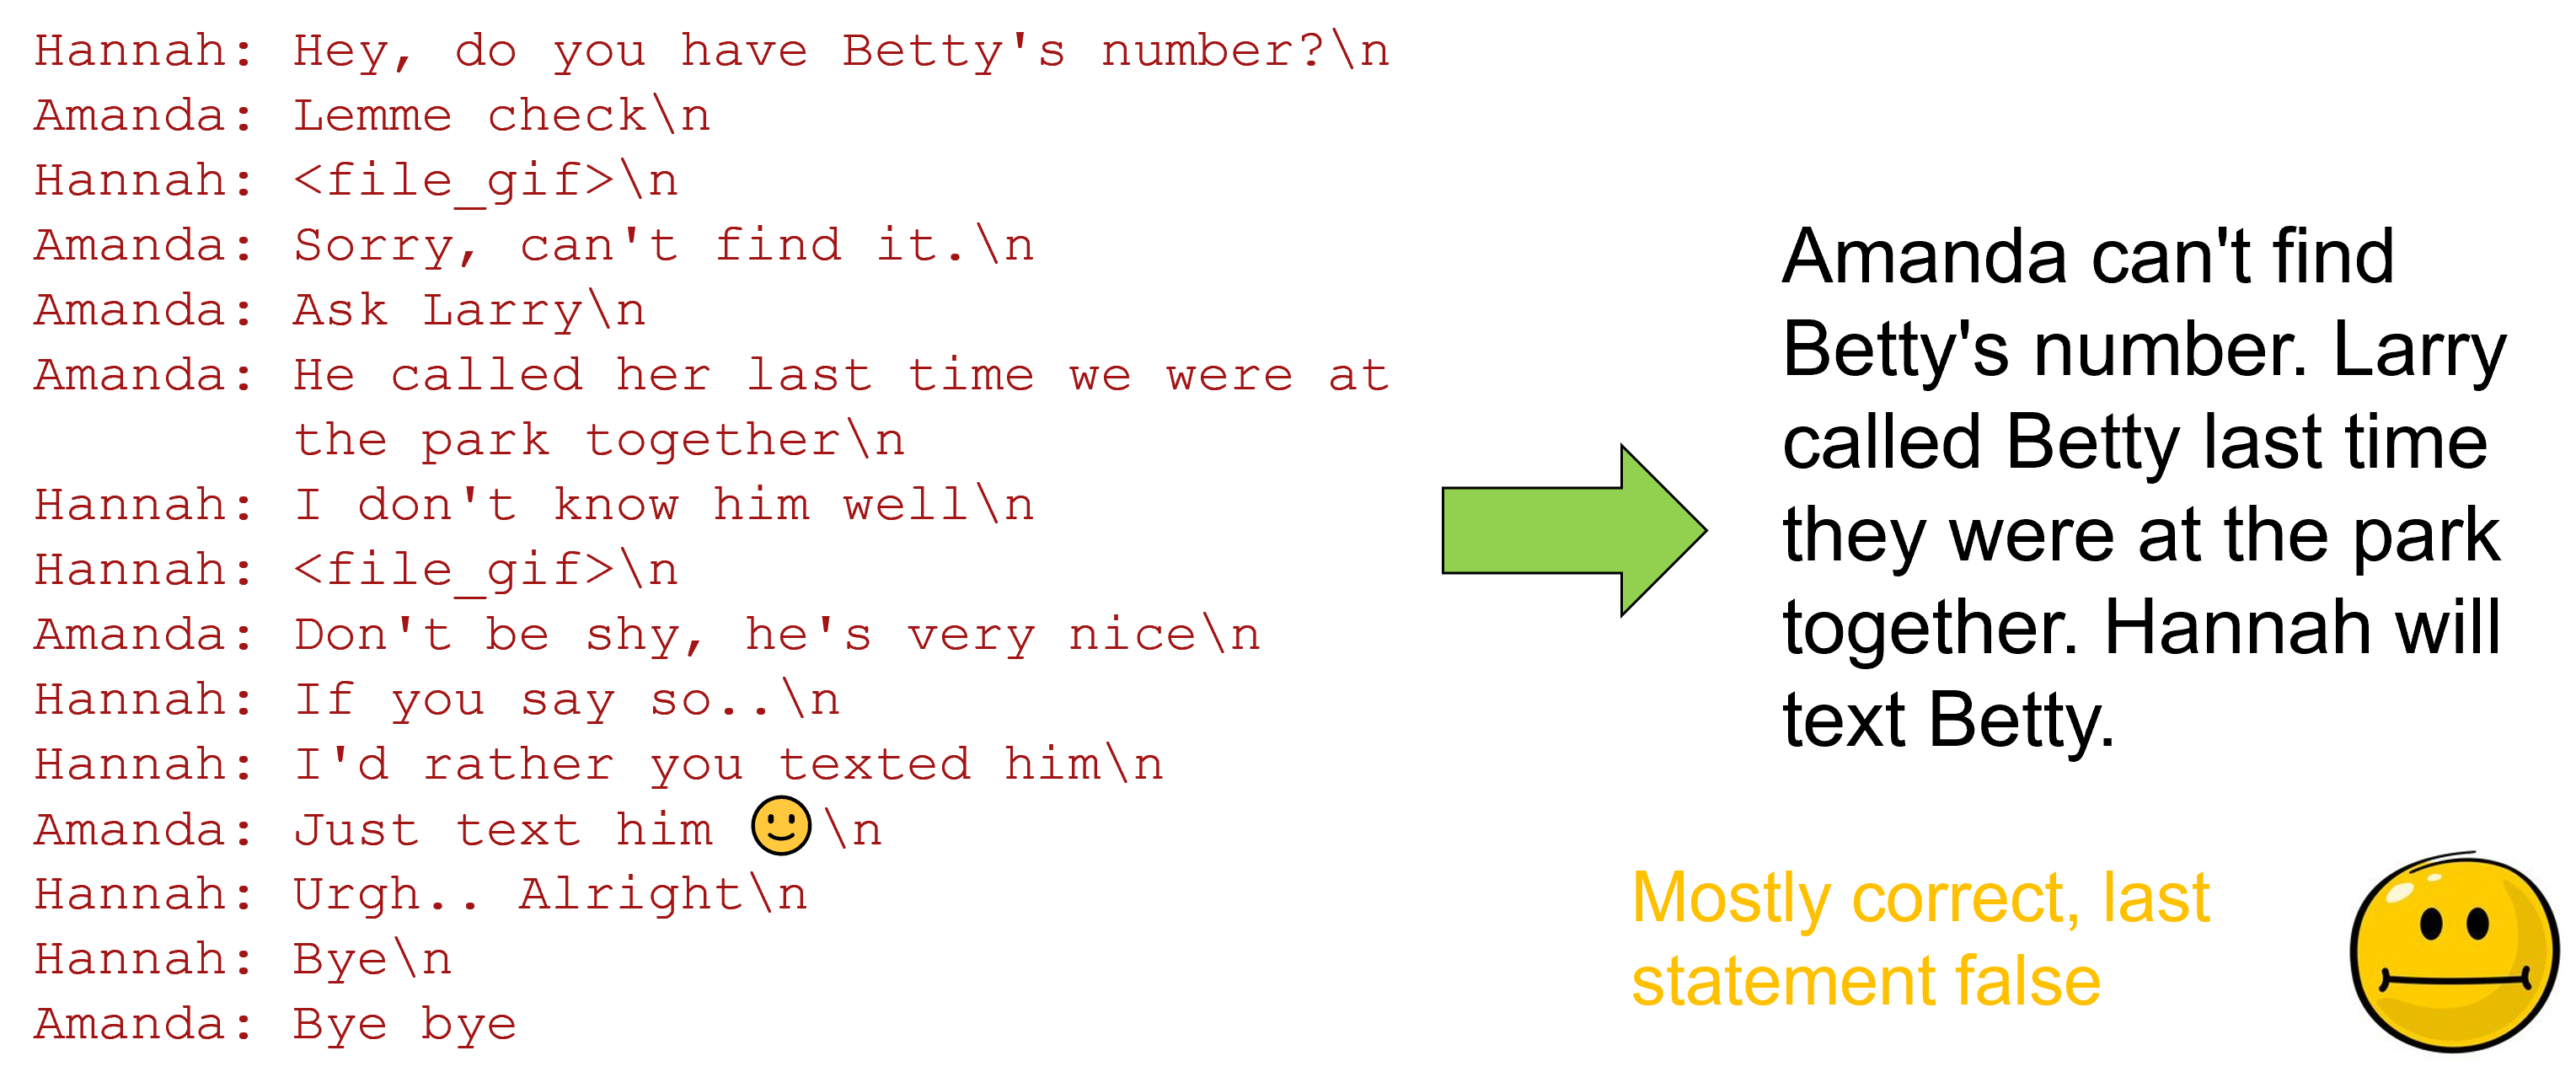

A quite good performence is achieved when summarazing compact text content (Wikipedia Article):

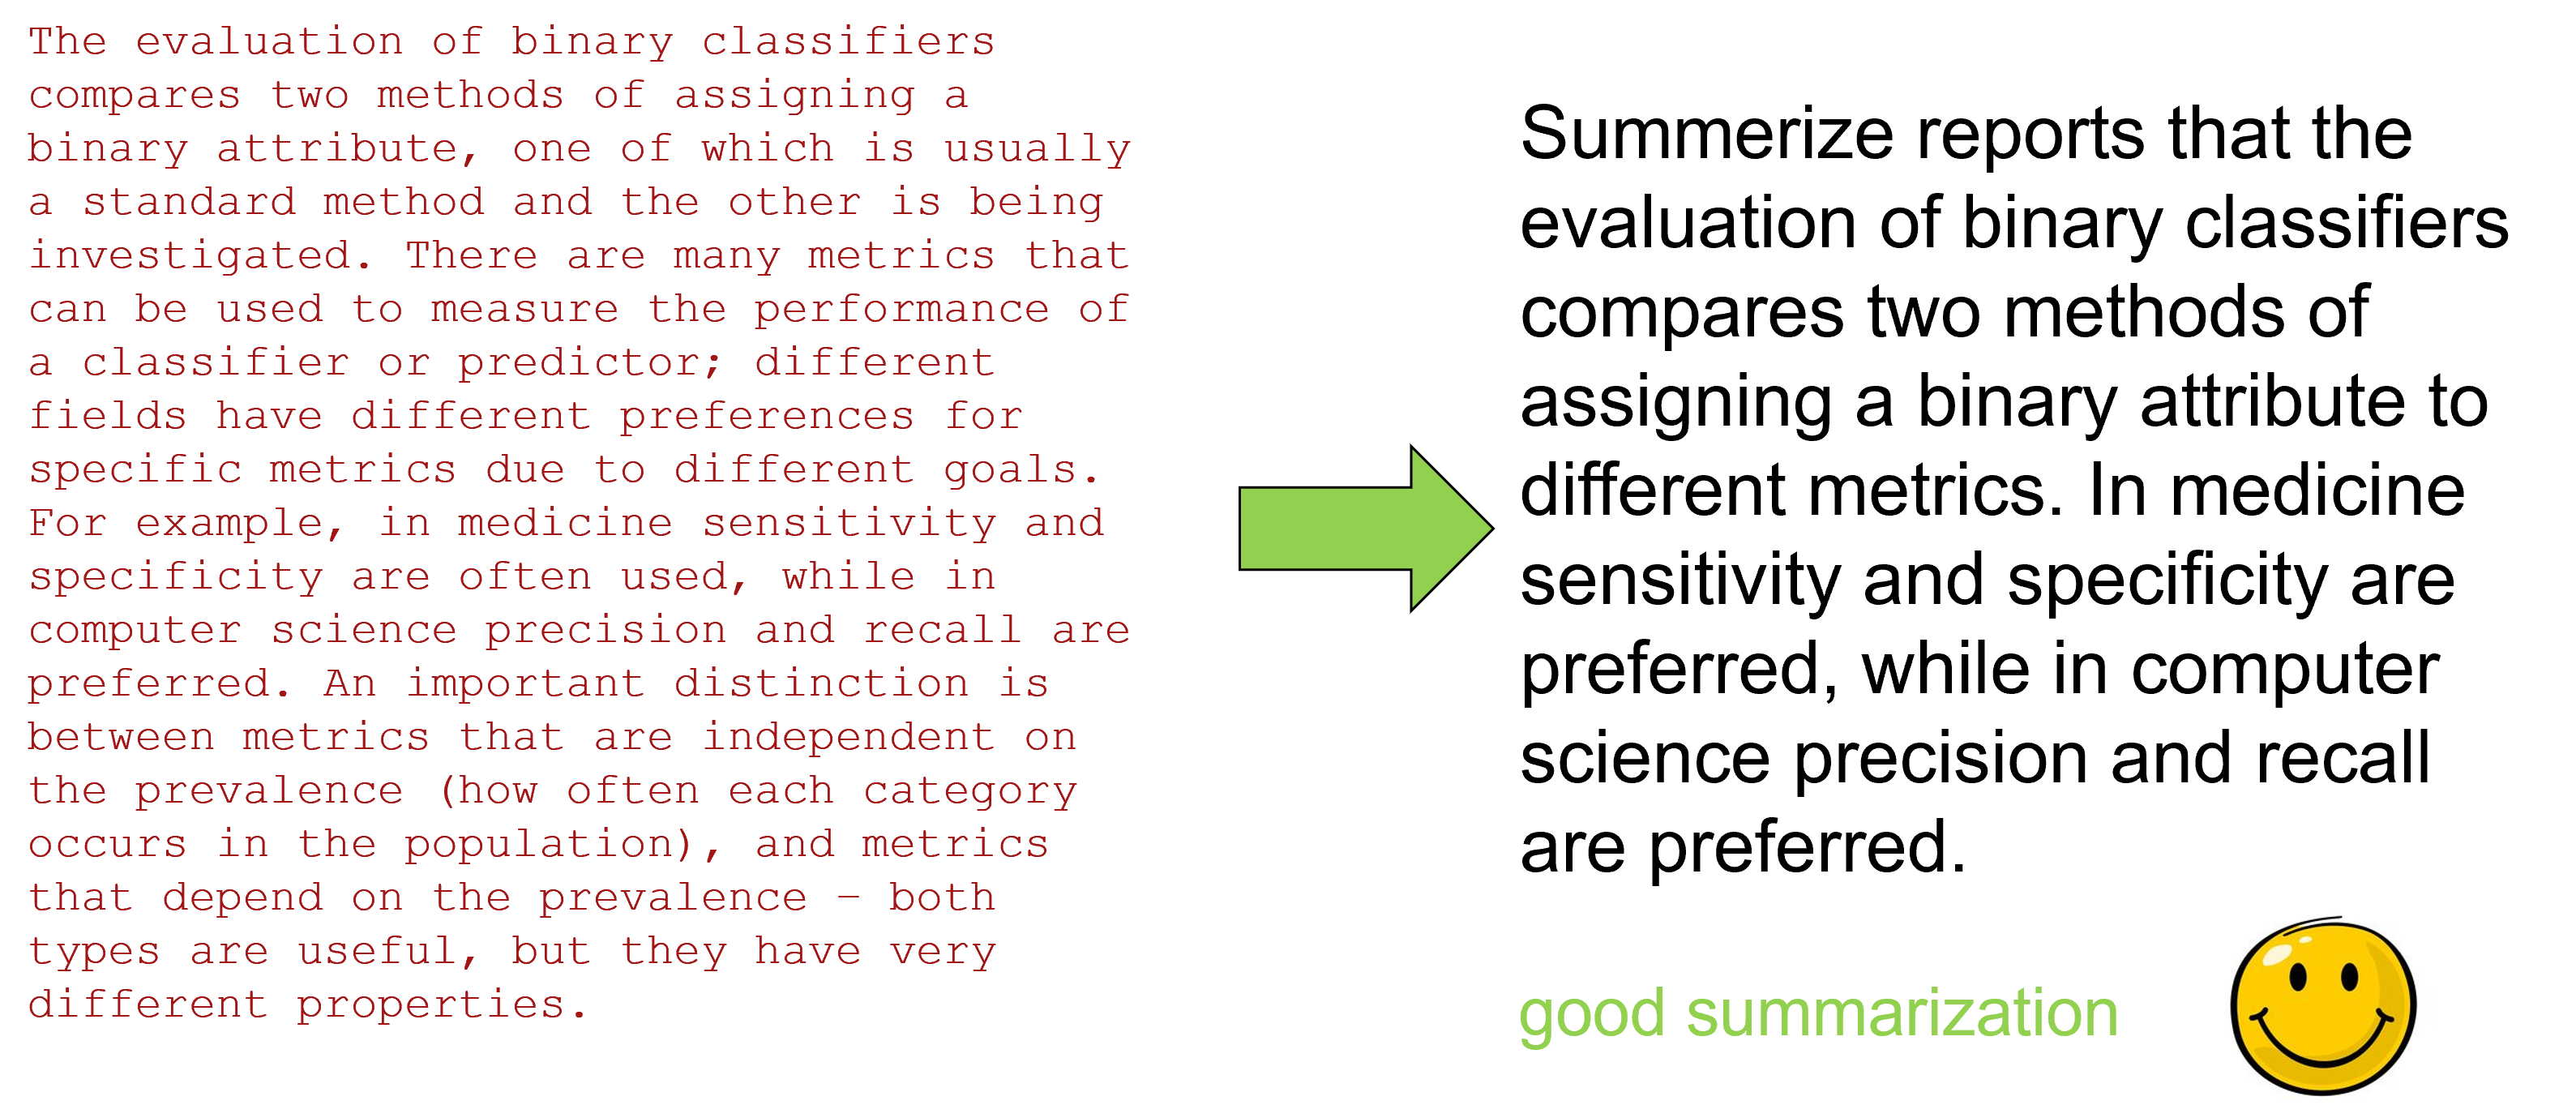

# D Discussion


The pre-trained model was fine-tuned to the task of summarising chats. It was trained on the basis of the SAMSum dataset. A semantically correct summary of a chat in which several people chat with each other, contradict each other, misunderstandings occur, slang and abbreviations are used is much more demanding than summarising a factually written article (Wikipedia article). The model performs accordingly. The summary of the chat has semantic errors, while the summary of the Wikipedia article works well.

# E Limitations of Approach